# Predicting Airbnb Price of listing per Night

Since its inception in 2008, Airbnb has disrupted the traditional hospitality industry as more travellers decide to use Airbnb as their primary means of accommodation. Airbnb offers travellers a more unique and personalized way of accommodation and experience

This dataset has columns describing:

- host id: unique host id
- host name: name of host
- listing id: unique listing id
- listing name: name of listing
- latitude
- longitude
- the neighbourhood: name of neighbourhood
- room type
- minimum number of nights
- number of reviews
- last review date
- reviews per month 
- availability_365: number of days in year the listing is available for rent
- host listings
- city
- price: price of listing per night

Acknowledgements

This dataset is a compilation of multiple datasets found on Inside Airbnb.

In [1]:
# regular expressions
import re 

# math and data utilities
import numpy as np
import pandas as pd
import scipy.stats as ss
import itertools as it

# ML and statistics libraries
import xgboost as xgb
import scipy.stats as stats
from scipy.special import boxcox1p
import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVC
import lightgbm as lgb

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [90]:
df = pd.read_csv('/Users/rosagradilla/Documents/Projects/data/AB_US_2020.csv')

/Users/rosagradilla/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [91]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [92]:
display(df.shape)
display(df.info())

(226030, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226030 entries, 0 to 226029
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              226030 non-null  int64  
 1   name                            226002 non-null  object 
 2   host_id                         226030 non-null  int64  
 3   host_name                       225997 non-null  object 
 4   neighbourhood_group             110185 non-null  object 
 5   neighbourhood                   226030 non-null  object 
 6   latitude                        226030 non-null  float64
 7   longitude                       226030 non-null  float64
 8   room_type                       226030 non-null  object 
 9   price                           226030 non-null  int64  
 10  minimum_nights                  226030 non-null  int64  
 11  number_of_reviews               226030 non-null  int64  
 12  last_review     

None

This dataset consists of 226,030 observations with 16 features plus our target variable, which we are predicting: <b>price of listing per night</b>

In [93]:
df.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
id,226030.0,2.547176e+07,1.317814e+07,109.00000,1.515890e+07,2.590916e+07,3.772624e+07,4.556085e+07
host_id,226030.0,9.352385e+07,9.827422e+07,23.00000,1.399275e+07,5.138266e+07,1.497179e+08,3.679176e+08
latitude,226030.0,3.566283e+01,6.849855e+00,18.92099,3.276178e+01,3.726112e+01,4.072404e+01,4.773462e+01
longitude,226030.0,-1.032207e+02,2.622209e+01,-159.71490,-1.185981e+02,-9.781720e+01,-7.691932e+01,-7.099595e+01
price,226030.0,2.197165e+02,5.703536e+02,0.00000,7.500000e+01,1.210000e+02,2.010000e+02,2.499900e+04
minimum_nights,226030.0,4.525490e+02,2.103376e+05,1.00000,1.000000e+00,2.000000e+00,7.000000e+00,1.000000e+08
number_of_reviews,226030.0,3.450653e+01,6.360291e+01,0.00000,1.000000e+00,8.000000e+00,3.900000e+01,9.660000e+02
reviews_per_month,177428.0,1.431450e+00,1.683210e+00,0.01000,2.300000e-01,8.100000e-01,2.060000e+00,4.406000e+01
calculated_host_listings_count,226030.0,1.669856e+01,5.106897e+01,1.00000,1.000000e+00,2.000000e+00,6.000000e+00,5.930000e+02
availability_365,226030.0,1.593149e+02,1.401796e+02,0.00000,0.000000e+00,1.400000e+02,3.110000e+02,3.650000e+02


## Exploratory Data Analysis (EDA)

First, I will focus on exploring missing values. I also will look at which features have the greatest impact on price. I also want to evaluate the relationship between variables. After this analysis is complete I will move on to predictive analysis.

Predicting price is a regression problem, therefore I be focusing on the following:

- <b>Variable Distributions: </b> We want to make sure our continuos variables are bell shaped for the purposes of having appropiate data to feed to our regression model.

- <b> Finding and Dealing with Missing Data: </b> We need to analyze the missing values in each one of our features and deal with them appropiately.

- <b>Linearity of Continuos Variables: </b> If our features have have linear relationships with price, we do not need to transform our data. However, if there isn't a linear relationship, then we must either transform the data or consider non-linear regression models.

- <b>Strength of Association: </b> We need to evaluate how strong is the relationship between a variable and our target, price. This would help us determine wether or not we should keep a variable.

- <b>ANOVA F-test of categorical variables against sale price: </b> Through ANOVA, we will  look at an outcome after using each one of the categories in a categorical variable. This will help us determine if a categorical variable is significant or not.

## Distribution of Target Variable: Price

First, I will plot the target variable along with a couple of transformations if necessary. We'll do this because:

1. We want to understand the distribution of our data and we can roughly determine that visually.

2. Transforming the distributions of the variables is common practice in case the data is not bell shaped.

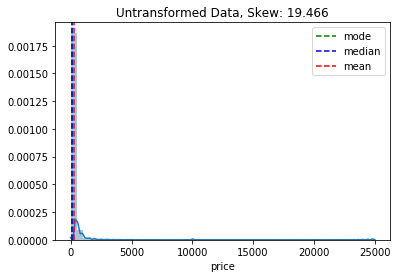

In [39]:
sigma = df.price.std()
mu = df.price.mean()
med = df.price.median()
mode = df.price.mode().to_numpy()

plt.title(f'Untransformed Data, Skew: {stats.skew(df.price):.3f}')
sns.distplot(df.price)
plt.axvline(mode, linestyle='--', color='green', label='mode')
plt.axvline(med, linestyle='--', color='blue', label='median')
plt.axvline(mu, linestyle='--', color='red', label='mean')
plt.legend()

It is very clear our response variable is right skewed, so we must transform it, We'll try log and Yeo-Johnson transformations and see which one looks better. We'll keep this in mind for when it is time to make predictions

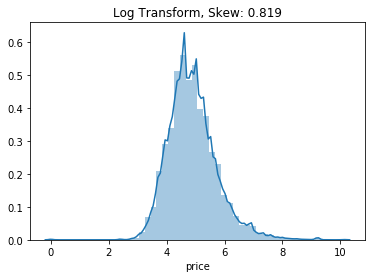

In [40]:
# Log Transform
log_data = np.log1p(df.price)
plt.title(f'Log Transform, Skew: {stats.skew(log_data):.3f}')
sns.distplot(np.log1p(df.price), kde=True)

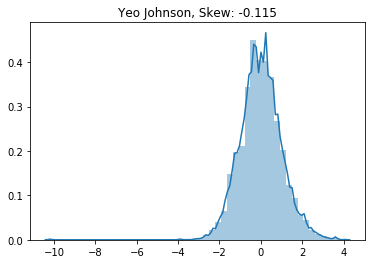

In [41]:
#Yeo-Johnson
pt = pre.PowerTransformer()
ptd = pt.fit_transform(df.price.to_numpy().reshape(-1,1))
plt.title(f'Yeo Johnson, Skew: {stats.skew(ptd.squeeze()):.3f}')
sns.distplot(ptd, kde=True)

These transformations alter the meaning of the data (notice the lack of the ‘Price’ label on the horizontal axis). The main purpose of transforming the target variable is in hopes of assisting the training of a machine learning algorithm.

The Yeo-Johnson transformation looks better than the log, we'll use that one later on.

## Checking Basic Intuitions

Let's check basic intuitions. For example, we can look at number of reviews against price and room type:

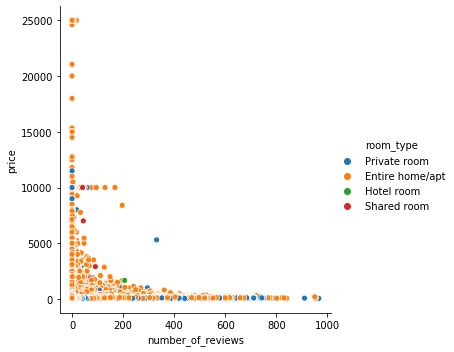

In [42]:
sns.relplot(x='number_of_reviews', y='price', hue='room_type', data=df)

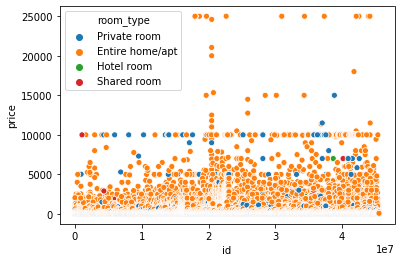

In [43]:
sns.scatterplot(x='id', y='price', hue='room_type', data=df)

We can see there are some listings that are above 10,000 per night. I am not sure if these are mistakes or real listings but since they are outliers I will remove them.

In [94]:
drop_mask = df.price > 5000
drop_idx = df[drop_mask].index
df = df.drop(drop_idx)

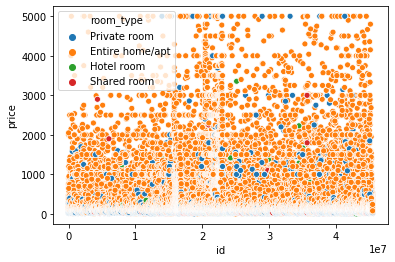

In [95]:
# verify outliers are dropped
sns.scatterplot(x='id', y='price', hue='room_type', data=df)

Let's see how many cities we have:

In [96]:
cities = df.city.unique()
display(f'There are {len(cities)} in the dataset')

display(cities)

'There are 28 in the dataset'

array(['Asheville', 'Austin', 'Boston', 'Broward County', 'Cambridge',
       'Chicago', 'Clark County', 'Columbus', 'Denver', 'Hawaii',
       'Jersey City', 'Los Angeles', 'Nashville', 'New Orleans',
       'New York City', 'Oakland', 'Pacific Grove', 'Portland',
       'Rhode Island', 'Salem', 'San Clara Country', 'San Diego',
       'San Francisco', 'San Mateo County', 'Santa Cruz County',
       'Seattle', 'Twin Cities MSA', 'Washington D.C.'], dtype=object)

## Dealing with Missing Values

Now we will focus on missing data. We want to know if any feature has an outstanding amount of missing values because if that's the case then we must get rid of that feature. We should also change "NaN to "NA".

The pipeline is:

1. Look at missing data points for specific variables.
2. See if the variable associated with that missing data is connected to a second variable
3. Determine if the missing data can be accounted for by a related variable.

In [97]:
# A function to vizualize missing data in a DataFrame

def viz_missing(df):

    missing = pd.DataFrame({
        'Missing':df.isnull().sum(),
        '% Missing': df.isnull().sum()/len(df)
    })
    missing = missing[missing['% Missing'] > 0].sort_values(by='Missing', ascending=False)
    sns.barplot(x=missing.index, y='% Missing', data=missing)
    plt.xticks(rotation=45)
    plt.show()

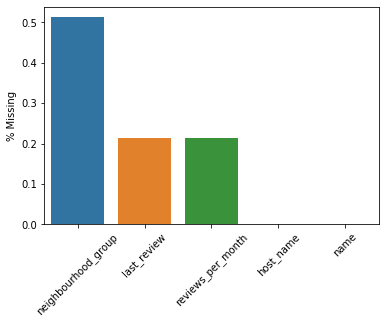

In [98]:
viz_missing(df)

So here we see that 50% of neighbourhood group is missing. Because a lot of these data points are missing, we are going to need to get rid of that feature.

The second one in line in last review, this is the date the last review was written. I do not think this feature will be useful for price prediction so I will also get rid of it.

Lastly, reviews_per_month might be useful but I am not 100% sure, we'll see.

In [99]:
reviws_per_month_nulls = df.loc[df.reviews_per_month.isnull()]
reviws_per_month_nulls[0:5]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
187,6775949,Cozy Cottage short walk to Downtown,35473023,Sherri,NaN,28801,35.60335,-82.55166,Entire home/apt,86,30,0,NaN,NaN,2,344,Asheville
286,12182918,MONTHLY - Grove Park - Charming Guest House,183656,Kim,NaN,28804,35.61164,-82.54167,Entire home/apt,72,30,0,NaN,NaN,1,107,Asheville
416,15359380,"5 Points Bungalow, Your Home in Asheville",3677108,Charles & Cheryl,NaN,28801,35.60388,-82.55727,Entire home/apt,214,30,0,NaN,NaN,3,327,Asheville
629,20255923,Sunrise Perch - High on a mountain & close-in,144357357,Sunrise,NaN,28806,35.58531,-82.64269,Private room,39,1,0,NaN,NaN,1,83,Asheville
720,21513021,2 Bedroom Condo blocks to Downtown Asheville,21500666,Rory,NaN,28801,35.60179,-82.55590,Entire home/apt,200,30,0,NaN,NaN,1,178,Asheville


In [100]:
df.reviews_per_month.fillna('NA', inplace=True)

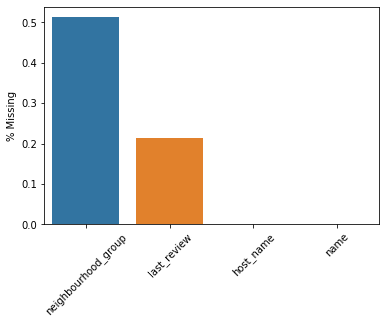

In [101]:
viz_missing(df)

In [102]:
# drop features
df = df.drop(['id', 'host_id', 'name', 'host_name', 'neighbourhood_group', 'last_review'], axis=1)

In [103]:
df.columns

Index(['neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'city'],
      dtype='object')

In [104]:
df = df.drop(['neighbourhood', 'reviews_per_month', 'calculated_host_listings_count'], axis=1)

In [105]:
df.columns

Index(['latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'availability_365', 'city'],
      dtype='object')

So I got rid of many features which I do not think will be helpful for our machine learning algorithm. Here is our updated dataset:

In [106]:
df.head()

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,availability_365,city
0,35.65146,-82.62792,Private room,60,1,138,0,Asheville
1,35.59779,-82.55540,Entire home/apt,470,1,114,288,Asheville
2,35.60670,-82.55563,Entire home/apt,75,30,89,298,Asheville
3,35.57864,-82.59578,Entire home/apt,90,1,267,0,Asheville
4,35.61442,-82.54127,Private room,125,30,58,0,Asheville


## Strength of Relationship Between Variables

Now that we have filled missing. Now we are almost ready for statistical analysis, but first: let's convert our non-numeric data to number format. We can have three types of variables:

- continuous: numerical data, it could be any number
- ordinal: non-continuous but with an underlying rank structure.
- nominal: categorical variable without any underlying rank or order.

If our variables are ordinal we must preserve the order.

In [107]:
df.columns

Index(['latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'availability_365', 'city'],
      dtype='object')

In [108]:
exp_contin = ['latitude', 'longitude', 'price', 'minimum_nights',
             'number_of_reviews', 'availability_365']

exp_nominal = ['room_type', 'city']

In this particular dataset we do not have any ordinal features, only continuous and nominal.

## Relationships between Variables

Now we will look at the relationship between our predictor variables and our target. Because we also have some categorical features we need to evaluate how to measure association

### Overview by Heatmap (continuous variables)

We will look at our continuous variables correlation with the target: price. Correlation by definition is the strength of a linear relationship.

Text(0.5, 1, 'Continuous Data')

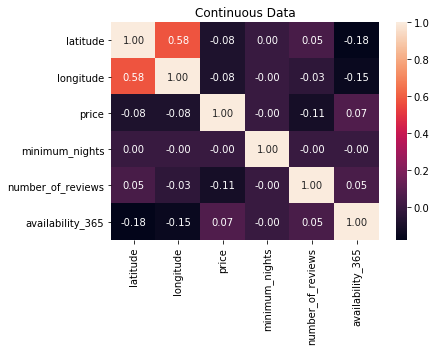

In [109]:
contin_corr = df[exp_contin].corr()

sns.heatmap(contin_corr, annot=True, fmt='0.2f').set_title('Continuous Data')

Longitude and latitude seem to be the only features that are highly correlated.

### Categorical Data (Nominal)

For our nominal data we will look at box plots for each of our nominal variables. We want to answer questions like "Is the average price of a listing significantly different between room types or cities?".

Our nominal variables are:

- room_type
- city

#### Room type

I will create a boxplot of room types ordered by the average price of listing. 

In [110]:
# For ordering the boxplots by median
grouped = df.loc[:, ['room_type', 'price']] \
            .groupby(['room_type']) \
            .mean() \
            .sort_values(by='price')

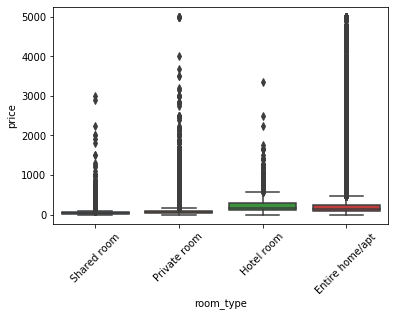

In [111]:
chart = sns.boxplot(x=df.room_type, y=df.price, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

After looking at this boxplot I realized I still have a lot of outliers for some reason. I would like to limit the price at 1,000 per night because I think this is a little more normal and representative of the population

In [112]:
drop_mask = df.price > 1000
drop_idx = df[drop_mask].index
df2 = df.drop(drop_idx)

In [113]:
grouped = df2.loc[:, ['room_type', 'price']] \
            .groupby(['room_type']) \
            .mean() \
            .sort_values(by='price')

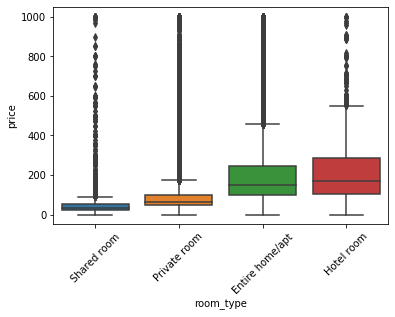

In [115]:
chart = sns.boxplot(x=df2.room_type, y=df2.price, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [117]:
city_grouped = df2.loc[:, ['city', 'price']] \
            .groupby(['city']) \
            .mean() \
            .sort_values(by='price')

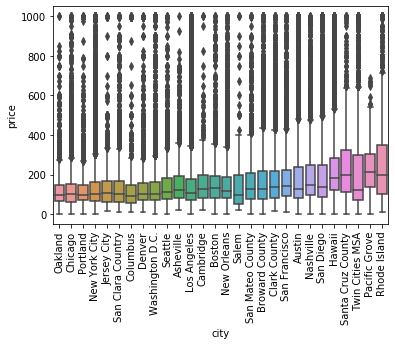

In [121]:
chart = sns.boxplot(x=df2.city, y=df2.price, order=city_grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

Now we will perform ANOVA on the data to see if the difference between room type or city is statistically significant.

In [123]:
def anova(df, predictor, target, alpha=0.05):
    
    # get unique, independent treatments (categories in predictory)
    treatments = df.loc[df[predictor].notnull(), predictor].unique()
    group_values = []
    
    # group target variable by category
    for t in treatments:
        group_values.append(df.loc[df[predictor] == t, target].to_numpy())
    
    # calculate degrees of freedom and confidence level
    k = len(treatments)
    n = df[predictor].notnull().sum()
    conf = 1 - alpha
    df1 = k - 1
    df2 = n - k
    
    # calculate critical value of F-distribution
    crit_val = stats.f.ppf(conf, df1, df2)
    
    # calculate F and p-values
    f, p = stats.f_oneway(*group_values)
    
    return f, p, crit_val

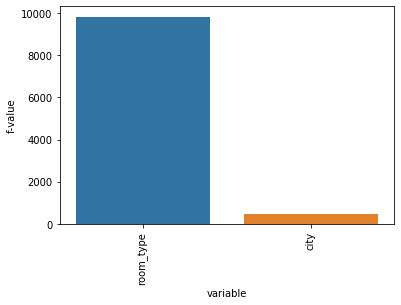

In [124]:
# DataFrame to hold ANOVA results.
f_frame = pd.DataFrame(columns=['variable','p-value','f-value', 'critical', 'passed'])

# Perform ANOVA on each variable. Store data for plotting
for var in exp_nominal:
    f, p, c = anova(df2, var, 'price')
    f_frame.loc[len(f_frame)] = [var, p, f, c, (f > c)]

# Plot test results
f_frame.sort_values(by='f-value', ascending=False, inplace=True)

# sns.set(rc={'figure.figsize':(15,8)})
sns.barplot(x='variable', y='f-value', data=f_frame)
plt.xticks(rotation=90)
plt.show()

In [126]:
f_frame.loc[f_frame.passed == True]

,variable,p-value,f-value,critical,passed
0,room_type,0.0,9816.399026,2.604949,True
1,city,0.0,472.085797,1.485727,True


This means our variables passed the F-test: <b>there is significant variation in price by category within each variable.</b>

## Getting Ready to Train a Model